<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [3]:
!unzip Skin.zip

In [4]:
!pip install torchutils

In [5]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
device = 'cuda'
print(device)

cuda


In [7]:
trnsfrms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
    ]
)

In [8]:
train_dataset = torchvision.datasets.ImageFolder(
    'train',
    transform=trnsfrms
)
valid_dataset = torchvision.datasets.ImageFolder(
    'test',
    transform=trnsfrms
)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True)

In [10]:
from torchvision.models import resnet50, ResNet50_Weights

In [11]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


In [12]:
model.fc = nn.Linear(2048, 1)

In [13]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}
idx2class

{0: 'benign', 1: 'malignant'}

In [15]:
# «Замораживаем» параметры
for param in model.parameters():
    param.requires_grad = False

# «Размораживаем» те веса, которые будем
# обучать
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

model.to(device);

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [17]:
def compute_batch_accuracy(preds, labels):
    preds_reshaped = preds.squeeze(-1)
    # print(preds_reshaped)
    preds_sigmoid  = preds_reshaped.sigmoid()
    # print(preds_sigmoid)
    preds_classes  = torch.round(preds_sigmoid)
    # print(preds_classes)
    bool_array     = preds_classes == labels
    # print(bool_array)
    number_of_true = bool_array.sum()
    # print(number_of_true)
    accuracy       = number_of_true / len(labels)
    # print(accuracy)
    accuracy_float = accuracy.item()

    return accuracy_float

In [18]:
model.to(device)

def fit(model: torch.nn.modules.container.Sequential, n_epochs: int, optimizer: torch.optim.Optimizer) -> tuple:
  train_epoch_acc = []
  train_epoch_losses = []
  valid_epoch_losses = []
  valid_epoch_acc =[]

  for epoch in range(n_epochs):

      loss_batch = []
      acc_batch  = []

      model.train()
      for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)

          preds = model(images)

          loss = criterion(preds.squeeze(-1), labels.float())

          loss_batch.append(loss.item())
          acc_batch.append(compute_batch_accuracy(preds, labels))

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      train_epoch_losses.append(np.mean(loss_batch))
      train_epoch_acc.append(np.mean(acc_batch))

      model.eval()
      loss_batch = []
      acc_batch  = []
      for images, labels in valid_loader:
          images = images.to(device)
          labels = labels.to(device)
          preds = model(images)

          loss_batch.append(loss.item())
          acc_batch.append(compute_batch_accuracy(preds, labels))


      valid_epoch_losses.append(np.mean(loss_batch))
      valid_epoch_acc.append(np.mean(acc_batch))
      print(f'[Epoch {epoch:02d}] Train loss: {train_epoch_losses[-1]:.4f}, valid loss = {valid_epoch_losses[-1]:.4f} Train acc {train_epoch_acc[-1]:.4f} Valid acc {valid_epoch_acc[-1]:.4f}')
  return train_epoch_acc, train_epoch_losses, valid_epoch_losses, valid_epoch_acc

In [19]:
train_epoch_acc, train_epoch_losses, valid_epoch_losses, valid_epoch_acc = fit(model, 5, optimizer)

[Epoch 00] Train loss: 0.4429, valid loss = 0.3821 Train acc 0.7889 Valid acc 0.7341
[Epoch 01] Train loss: 0.3274, valid loss = 0.2673 Train acc 0.8603 Valid acc 0.8209
[Epoch 02] Train loss: 0.3066, valid loss = 0.3008 Train acc 0.8646 Valid acc 0.8473
[Epoch 03] Train loss: 0.2761, valid loss = 0.3386 Train acc 0.8813 Valid acc 0.8616
[Epoch 04] Train loss: 0.2496, valid loss = 0.2426 Train acc 0.8957 Valid acc 0.8784


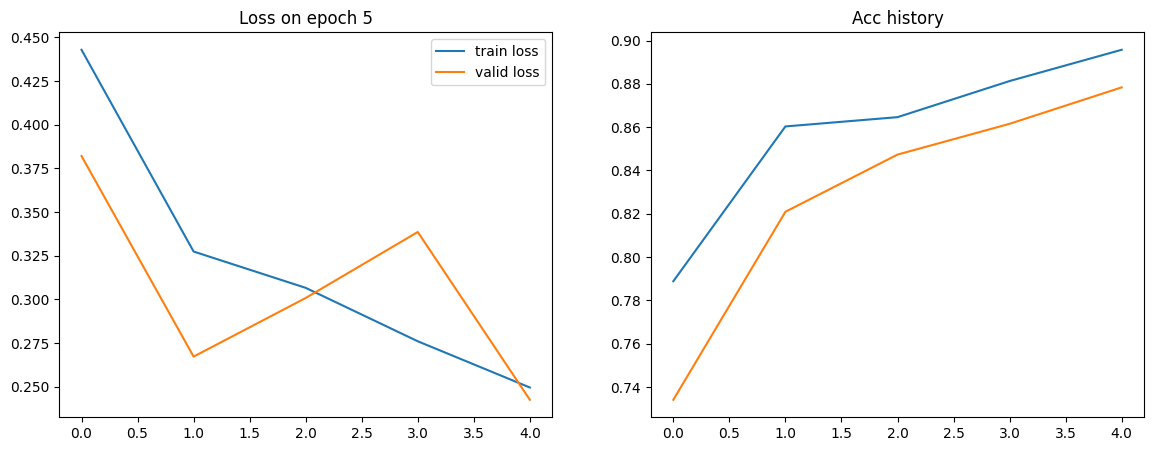

In [20]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(train_epoch_losses, label='train loss')
ax[0].plot(valid_epoch_losses, label='valid loss')
ax[0].set_title(f'Loss on epoch {len(train_epoch_losses)}')
ax[0].grid()
ax[0].legend()

ax[1].plot(train_epoch_acc)
ax[1].plot(valid_epoch_acc)
ax[0].grid()
ax[1].set_title('Acc history');

In [21]:
resize = T.Resize((224, 224))

In [22]:
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

 На картинке должен быть malignant


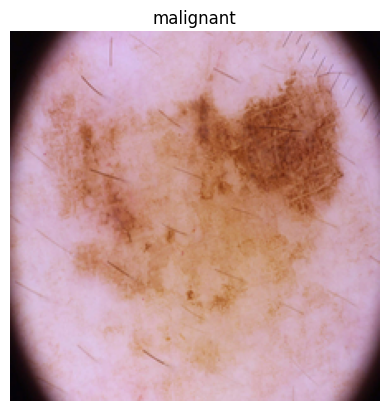

In [30]:
img = next(iter(valid_loader))
i = img[0][0]
c = img[1][0]
print(f' На картинке должен быть {idx2class[c.tolist()]}')
plt.imshow(torch.permute(i, (1, 2, 0)))
plt.title(idx2class[torch.sigmoid(model(i.unsqueeze(0).to(device))).round().item()])
plt.axis(False);

In [32]:
torch.save(model.state_dict(), 'resnet50weight.pt')